In [52]:
#imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from helpers.datasetHelper import get_samples, split_healthy_data
from pyswarm import pso

from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

from models import MyXGboost

In [53]:
def run_pso_with_progress(X, Y, estimator, n_features,
                          swarmsize=50, maxiter=10, threshold=0.7):
    lb = [0]*n_features
    ub = [1]*n_features
    progress = []

    # Create a scorer for Cohen's Kappa
    kappa_scorer = make_scorer(cohen_kappa_score)

    def objective_with_progress(weights, est, X_, Y_):
        Xw = X_ * weights
                
        # Use it in cross_val_score
        fit = 1 - cross_val_score(est, Xw, Y_, cv=5, scoring=kappa_scorer).mean()
        progress.append(fit)
        
        if len(progress) % 10 == 0:
            print(f"Eval {len(progress)}: best fitness so far = {min(progress):.4f}")
        return fit

    best_pos, best_fit = pso(
        objective_with_progress,
        lb, ub,
        args=(estimator, X, Y),
        swarmsize=swarmsize,
        maxiter=maxiter
    )

    mask = best_pos > threshold
    selected_features = np.where(mask)[0].tolist()
    return best_pos, best_fit, progress, selected_features

In [54]:

directory_path = './datasets'
data_health = get_samples(os.path.join(directory_path, 'DT.Healthy.csv'))

# Load the PAN-CANCER-TRANSPOSED.csv data
healthy_cases, prebrca_cases, cancer_cases = split_healthy_data(data_health)

# Combine the data into a single dataframe
# Tag each list of cases
healthy_cases = pd.DataFrame(healthy_cases)
healthy_cases['Tag'] = 'HEALTHY'
prebrca_cases = pd.DataFrame(prebrca_cases)
prebrca_cases['Tag'] = 'PRE-BRCA'
cancer_cases = pd.DataFrame(cancer_cases)
cancer_cases['Tag'] = 'BRCA'

print("Data loaded successfully.")

df_cancer = pd.concat([healthy_cases, prebrca_cases, cancer_cases], ignore_index=True) #blood samples
X = df_cancer.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
Y = df_cancer.iloc[:, -1]

feature_names = np.array(data_health[0][:-1])

# Fill missing values with the lowest value of its cpg site
X = X.apply(lambda col: col.fillna(col.min()), axis=0)

print(feature_names)  # Display first 5 feature names for brevity

n_features = X.shape[1]
print(f"Loaded dataset with {n_features} features and {len(Y)} samples")

# Use DecisionTreeClassifier as the estimator
estimator = MyXGboost.DecisionTreeMultiClass()


/Users/leandro/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257

Data loaded successfully.
['cg00000292' 'cg00002426' 'cg00003994' ... 'cg27662379' 'cg27662877'
 'cg27665659']
Loaded dataset with 27578 features and 790 samples


In [55]:

# 2) Run PSO
# For high-dimensional data (27k features), reduce swarmsize and maxiter for tractability
best_weights, best_fitness, progress, X_selected = run_pso_with_progress(
    X, Y, estimator, n_features,
    swarmsize=10,   # smaller swarm for memory/speed
    maxiter=100,      # fewer iterations to avoid long runtimes
    threshold=0.4  # higher threshold to select only strongest features
)
print(f"Done PSO → best fitness = {best_fitness:.4f}")

print(X_selected) 
print(best_fitness)
print(best_weights.shape)


# select features with PSO weight > 0.95
mask = best_weights > 0.4
X_selected = X.iloc[:, mask]
# how many features we kept
print(f"Threshold=0.9, selected {X_selected.shape[1]} features")
# Show the selected features
print("Selected features:")
selected_feature_names = feature_names[mask]
print(selected_feature_names)

Eval 10: best fitness so far = 0.5781
Eval 20: best fitness so far = 0.5781
Eval 30: best fitness so far = 0.5780
Eval 40: best fitness so far = 0.5780
Eval 50: best fitness so far = 0.5729
Eval 60: best fitness so far = 0.5545
Eval 70: best fitness so far = 0.5545
Eval 80: best fitness so far = 0.5542
Eval 90: best fitness so far = 0.5542
Eval 100: best fitness so far = 0.5542
Eval 110: best fitness so far = 0.5542
Eval 120: best fitness so far = 0.5542
Eval 130: best fitness so far = 0.5542
Eval 140: best fitness so far = 0.5542
Eval 150: best fitness so far = 0.5542
Eval 160: best fitness so far = 0.5542
Eval 170: best fitness so far = 0.5542
Eval 180: best fitness so far = 0.5542
Eval 190: best fitness so far = 0.5542
Eval 200: best fitness so far = 0.5542
Eval 210: best fitness so far = 0.5542
Eval 220: best fitness so far = 0.5542
Eval 230: best fitness so far = 0.5542
Eval 240: best fitness so far = 0.5542
Eval 250: best fitness so far = 0.5542
Eval 260: best fitness so far = 0.

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from deap import base, creator, tools, algorithms
import random

def run_ga_with_progress(X, Y, estimator, n_features,
                        pop_size=50, n_generations=100, threshold=0.7,
                        cx_prob=0.5, mut_prob=0.2, tournament_size=3):
    """
    Genetic Algorithm for feature selection with progress tracking.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    Y : array-like, shape (n_samples,)
        Target values
    estimator : sklearn estimator
        The machine learning model to use for evaluation
    n_features : int
        Number of features in the dataset
    pop_size : int, default=50
        Size of the population
    n_generations : int, default=10
        Number of generations to evolve
    threshold : float, default=0.7
        Threshold for feature selection (genes > threshold are selected)
    cx_prob : float, default=0.5
        Crossover probability
    mut_prob : float, default=0.2
        Mutation probability
    tournament_size : int, default=3
        Tournament size for selection
    
    Returns:
    --------
    best_individual : list
        Best individual (feature weights) found
    best_fitness : float
        Best fitness value achieved
    progress : list
        List of fitness values during evolution
    selected_features : list
        Indices of selected features based on threshold
    """
    
    progress = []
    
    # Create a scorer for Cohen's Kappa
    kappa_scorer = make_scorer(cohen_kappa_score)
    
    # DEAP setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    
    # Gene initialization (random float between 0 and 1)
    toolbox.register("attr_float", random.random)
    
    # Individual initialization
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                    toolbox.attr_float, n_features)
    
    # Population initialization
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def evaluate_individual(individual):
        """Evaluate an individual using cross-validation with Cohen's Kappa"""
        weights = np.array(individual)
        Xw = X * weights
        
        # Use cross-validation with Cohen's Kappa
        kappa_scores = cross_val_score(estimator, Xw, Y, cv=5, scoring=kappa_scorer)
        fitness = 1 - kappa_scores.mean()  # Minimize (1 - kappa)
        
        progress.append(fitness)
        
        if len(progress) % 10 == 0:
            print(f"Eval {len(progress)}: best fitness so far = {min(progress):.4f}")
        
        return (fitness,)
    
    # Register genetic operators
    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=tournament_size)
    
    # Create initial population
    pop = toolbox.population(n=pop_size)
    
    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    # Evolution loop
    for generation in range(n_generations):
        print(f"Generation {generation + 1}/{n_generations}")
        
        # Select parents
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Apply mutation
        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                # Clip values to [0, 1] range
                for i in range(len(mutant)):
                    mutant[i] = max(0, min(1, mutant[i]))
                del mutant.fitness.values
        
        # Evaluate offspring with invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Replace population
        pop[:] = offspring
    
    # Find best individual
    best_individual = tools.selBest(pop, 1)[0]
    best_fitness = best_individual.fitness.values[0]
    
    # Select features based on threshold
    mask = np.array(best_individual) > threshold
    selected_features = np.where(mask)[0].tolist()
    
    # Clean up DEAP classes to avoid conflicts in future runs
    del creator.FitnessMin
    del creator.Individual
    
    return list(best_individual), best_fitness, progress, selected_features


In [57]:
best_weights_ga, best_fitness_ga, progress_ga, X_selected_ga = run_ga_with_progress(
    X, Y, estimator, X.shape[1], 
    pop_size=30, n_generations=100, threshold=0.5
)
print(f"Done GA → best fitness = {best_fitness_ga:.4f}")
print(f"Number of selected features: {len(selected_feature_names)}")
print(f"Selected feature indices: {selected_feature_names[:10]}...")  # Show first 10

# Convert best_weights_ga to numpy array before comparison
best_weights_ga_array = np.array(best_weights_ga)
mask_ga = best_weights_ga_array > 0.9
X_selected_ga = X.iloc[:, mask_ga]

selected_feature_names_ga = feature_names[mask_ga]
print(selected_feature_names_ga)

Eval 10: best fitness so far = 0.5745
Eval 20: best fitness so far = 0.5745
Eval 30: best fitness so far = 0.5696
Generation 1/100
Eval 40: best fitness so far = 0.5696
Generation 2/100
Eval 50: best fitness so far = 0.5696
Eval 60: best fitness so far = 0.5696
Eval 70: best fitness so far = 0.5696
Generation 3/100
Eval 80: best fitness so far = 0.5696
Generation 4/100
Eval 90: best fitness so far = 0.5597
Eval 100: best fitness so far = 0.5597
Generation 5/100
Eval 110: best fitness so far = 0.5597
Eval 120: best fitness so far = 0.5537
Generation 6/100
Eval 130: best fitness so far = 0.5537
Eval 140: best fitness so far = 0.5537
Generation 7/100
Eval 150: best fitness so far = 0.5537
Eval 160: best fitness so far = 0.5537
Generation 8/100
Eval 170: best fitness so far = 0.5537
Eval 180: best fitness so far = 0.5537
Generation 9/100
Eval 190: best fitness so far = 0.5537
Eval 200: best fitness so far = 0.5537
Generation 10/100
Eval 210: best fitness so far = 0.5537
Eval 220: best fitn

In [ ]:
# Use LabelEncoder to encode the target classes
label_encoder = LabelEncoder()
# Define the order: Healthy -> Pre-BRCA -> BRCA
ordered_labels = ['HEALTHY', 'PRE-BRCA', 'BRCA']
label_encoder.fit(ordered_labels)
Y_encoded = label_encoder.transform(Y)

print(f"Encoded target classes: {label_encoder.classes_}")

# 1) evaluate with all features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42
)
# Apply SMOTE to balance the training instances
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
X_train_all, y_train_all = smote.fit_resample(X_train_all, y_train_all)

# 2) evaluate with selected features
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
    X_selected_ga, Y_encoded, test_size=0.2, random_state=42
)
# Apply SMOTE to balance the training instances
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
X_train_ga, y_train_ga = smote.fit_resample(X_train_ga, y_train_ga)

# 3) evaluate with PSO selected features
mask = best_weights > 0.9
X_selected_pso = X.iloc[:, mask]
X_train_pso, X_test_pso, y_train_pso, y_test_pso = train_test_split(
    X_selected_pso, Y_encoded, test_size=0.2, random_state=42
)
# Apply SMOTE to balance the training instances
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
X_train_pso, y_train_pso = smote.fit_resample(X_train_pso, y_train_pso)

Encoded target classes: ['BRCA' 'HEALTHY' 'PRE-BRCA']


/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [59]:
modes = [
    {
        'Name': 'RandomForest100',
        'Model': MyXGboost.RandomForest100()
    },
    {
        'Name': 'RandomForest200',
        'Model': MyXGboost.RandomForest200()
    },
    {
        'Name': 'RandomForest300',
        'Model': MyXGboost.RandomForest300()
    },
    {
        'Name': 'XGBoost',
        'Model': MyXGboost.XGBoostMultiClass()
    },
    {
        'Name': 'LightGBM',
        'Model': MyXGboost.LightGBMMulticlass()
    },
    {
        'Name': 'GradientBoosting',
        'Model': MyXGboost.GradientBoosting()
    }
]

Training data dimensions:
Original data (X_train_all): (1425, 27578)
GA selected features (X_train_ga): (1425, 2868)
PSO selected features (X_train_pso): (1425, 3411)

=== Results for GA selected features ===

Model: RandomForest100
Accuracy: 0.7848
F1 Score: 0.7954
ROC AUC: 0.9019
Kappa index: 0.5658


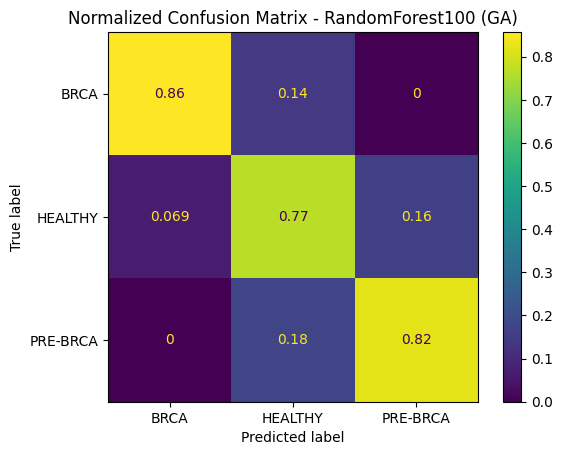


Top 20 important features:
1. cg27310234: 0.0183
2. cg16466334: 0.0135
3. cg10313675: 0.0128
4. cg15888522: 0.0117
5. cg25932713: 0.0113
6. cg02117021: 0.0111
7. cg20406878: 0.0110
8. cg23617121: 0.0110
9. cg01727899: 0.0087
10. cg07050831: 0.0086
11. cg19447966: 0.0082
12. cg18152517: 0.0082
13. cg04835638: 0.0079
14. cg24060938: 0.0078
15. cg01182873: 0.0077
16. cg17095279: 0.0076
17. cg09033997: 0.0076
18. cg16753209: 0.0076
19. cg02633817: 0.0074
20. cg12937434: 0.0074
--------------------------------------------------------------------------------

Model: RandomForest200
Accuracy: 0.7468
F1 Score: 0.7585
ROC AUC: 0.8987
Kappa index: 0.4812


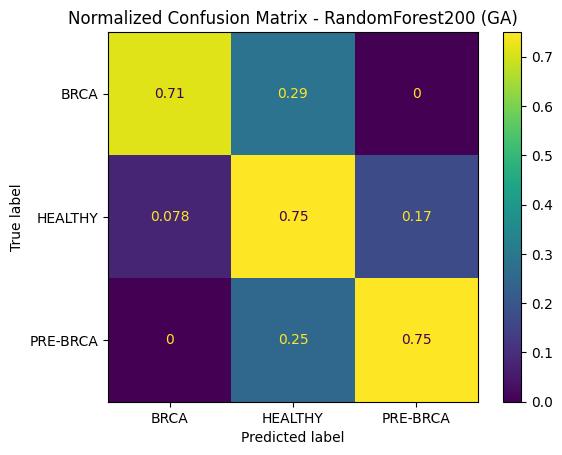


Top 20 important features:
1. cg10313675: 0.0142
2. cg27310234: 0.0131
3. cg24167928: 0.0110
4. cg23855818: 0.0096
5. cg02906939: 0.0093
6. cg02117021: 0.0093
7. cg16466334: 0.0081
8. cg19447966: 0.0078
9. cg21817450: 0.0076
10. cg09618387: 0.0075
11. cg08099701: 0.0074
12. cg06168050: 0.0067
13. cg01998146: 0.0066
14. cg20906802: 0.0065
15. cg18152517: 0.0063
16. cg24060938: 0.0061
17. cg15888522: 0.0060
18. cg19189291: 0.0059
19. cg13857440: 0.0058
20. cg26804057: 0.0058
--------------------------------------------------------------------------------

Model: RandomForest300
Accuracy: 0.7532
F1 Score: 0.7641
ROC AUC: 0.9030
Kappa index: 0.4911


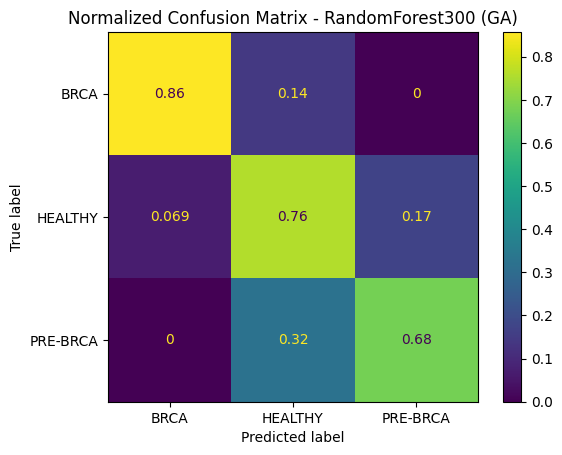


Top 20 important features:
1. cg08099701: 0.0115
2. cg20406878: 0.0114
3. cg04835638: 0.0098
4. cg10313675: 0.0095
5. cg24060938: 0.0090
6. cg13233799: 0.0089
7. cg08157638: 0.0087
8. cg17108383: 0.0087
9. cg02254461: 0.0086
10. cg02075593: 0.0085
11. cg04748010: 0.0081
12. cg18152517: 0.0080
13. cg27310234: 0.0073
14. cg25346576: 0.0072
15. cg14643520: 0.0067
16. cg25314216: 0.0063
17. cg15398520: 0.0063
18. cg26229648: 0.0062
19. cg08358671: 0.0062
20. cg17095279: 0.0061
--------------------------------------------------------------------------------
[0]	validation_0-mlogloss:1.04806
[1]	validation_0-mlogloss:1.00319
[2]	validation_0-mlogloss:0.96161


/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:13:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-mlogloss:0.92280
[4]	validation_0-mlogloss:0.88444
[5]	validation_0-mlogloss:0.84991
[6]	validation_0-mlogloss:0.81910
[7]	validation_0-mlogloss:0.78901
[8]	validation_0-mlogloss:0.76110
[9]	validation_0-mlogloss:0.73564
[10]	validation_0-mlogloss:0.71075
[11]	validation_0-mlogloss:0.68741
[12]	validation_0-mlogloss:0.66531
[13]	validation_0-mlogloss:0.64521
[14]	validation_0-mlogloss:0.62601
[15]	validation_0-mlogloss:0.60622
[16]	validation_0-mlogloss:0.58980
[17]	validation_0-mlogloss:0.57202
[18]	validation_0-mlogloss:0.55706
[19]	validation_0-mlogloss:0.54281
[20]	validation_0-mlogloss:0.52839
[21]	validation_0-mlogloss:0.51530
[22]	validation_0-mlogloss:0.50365
[23]	validation_0-mlogloss:0.49192
[24]	validation_0-mlogloss:0.48073
[25]	validation_0-mlogloss:0.46990
[26]	validation_0-mlogloss:0.45999
[27]	validation_0-mlogloss:0.44989
[28]	validation_0-mlogloss:0.44045
[29]	validation_0-mlogloss:0.43067
[30]	validation_0-mlogloss:0.42117
[31]	validation_0-mlogloss:

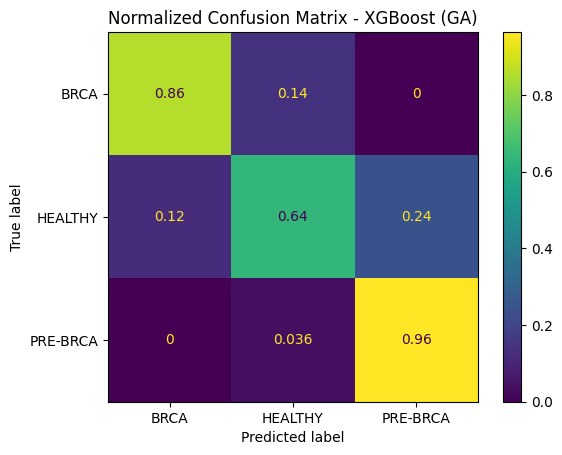


Top 20 important features:
1. cg19780563: 0.0267
2. cg08099701: 0.0222
3. cg20851245: 0.0189
4. cg05585544: 0.0168
5. cg04319097: 0.0148
6. cg19339848: 0.0147
7. cg08358671: 0.0124
8. cg03016571: 0.0107
9. cg07122495: 0.0107
10. cg16873684: 0.0106
11. cg17791936: 0.0094
12. cg27440002: 0.0090
13. cg24480194: 0.0089
14. cg10287137: 0.0085
15. cg16792632: 0.0083
16. cg11237115: 0.0082
17. cg12711530: 0.0082
18. cg09514038: 0.0081
19. cg27310234: 0.0081
20. cg04223956: 0.0080
--------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731340
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 2868
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from sc

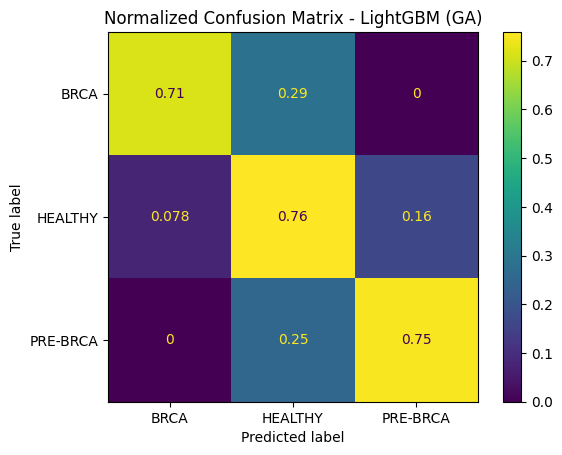


Top 20 important features:
1. cg26760212: 85.0000
2. cg01727899: 74.0000
3. cg20406878: 66.0000
4. cg04223956: 65.0000
5. cg23645091: 47.0000
6. cg09867157: 45.0000
7. cg02004156: 42.0000
8. cg13086467: 41.0000
9. cg23580000: 40.0000
10. cg14201417: 36.0000
11. cg27310234: 36.0000
12. cg18432105: 33.0000
13. cg00292662: 31.0000
14. cg19987219: 29.0000
15. cg05921699: 29.0000
16. cg10421192: 28.0000
17. cg08358671: 26.0000
18. cg00183782: 26.0000
19. cg19339848: 26.0000
20. cg06532147: 26.0000
--------------------------------------------------------------------------------

Model: GradientBoosting
Accuracy: 0.7405
F1 Score: 0.7537
ROC AUC: 0.8798
Kappa index: 0.4818


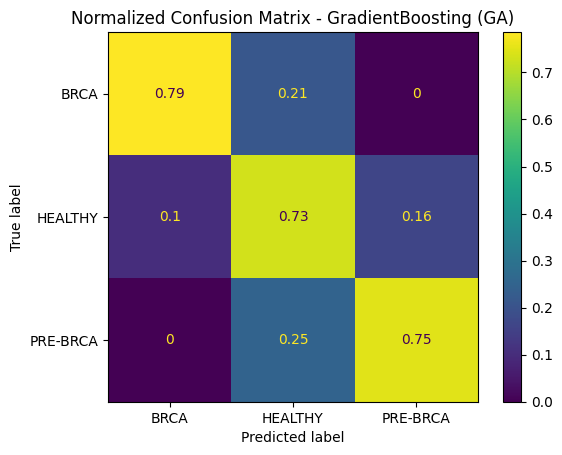


Top 20 important features:
1. cg15888522: 0.1927
2. cg08358671: 0.1763
3. cg01727899: 0.1226
4. cg09033997: 0.0246
5. cg07122495: 0.0241
6. cg06168050: 0.0210
7. cg24480194: 0.0204
8. cg05103623: 0.0136
9. cg25104030: 0.0127
10. cg27327588: 0.0127
11. cg04947838: 0.0117
12. cg20406878: 0.0105
13. cg26760212: 0.0092
14. cg18432105: 0.0088
15. cg24535573: 0.0085
16. cg01255349: 0.0085
17. cg24345793: 0.0081
18. cg13086467: 0.0078
19. cg05146205: 0.0071
20. cg01941619: 0.0070
--------------------------------------------------------------------------------

=== Results for PSO selected features ===

Model: RandomForest100
Accuracy: 0.7595
F1 Score: 0.7702
ROC AUC: 0.9201
Kappa index: 0.4993


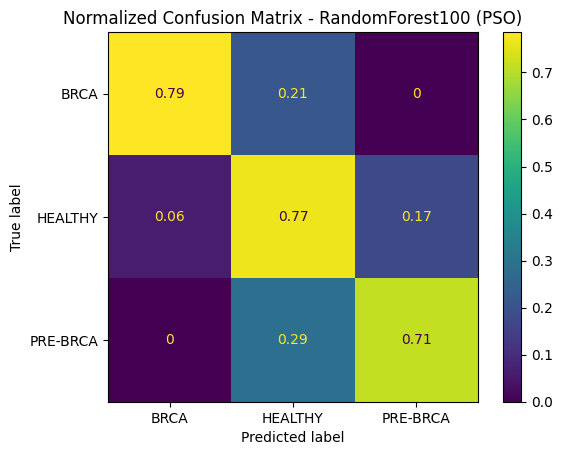


Top 20 important features:
1. cg00746981: 0.0150
2. cg03550002: 0.0144
3. cg03332970: 0.0129
4. cg02250992: 0.0111
5. cg03665605: 0.0092
6. cg02555579: 0.0090
7. cg00410831: 0.0090
8. cg03625911: 0.0083
9. cg01281797: 0.0082
10. cg01985090: 0.0081
11. cg00040873: 0.0080
12. cg05323436: 0.0077
13. cg03171924: 0.0077
14. cg03662459: 0.0076
15. cg03003060: 0.0076
16. cg03900542: 0.0075
17. cg00585846: 0.0075
18. cg00539322: 0.0074
19. cg01013324: 0.0074
20. cg01260219: 0.0074
--------------------------------------------------------------------------------

Model: RandomForest200
Accuracy: 0.7595
F1 Score: 0.7698
ROC AUC: 0.9088
Kappa index: 0.4999


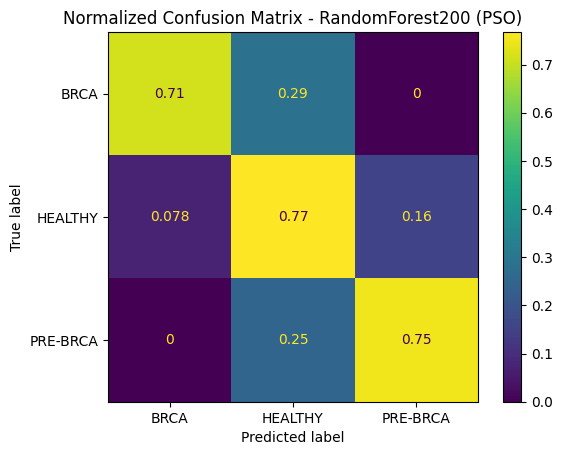


Top 20 important features:
1. cg02555579: 0.0117
2. cg02470959: 0.0102
3. cg00853068: 0.0096
4. cg01985090: 0.0084
5. cg03184439: 0.0078
6. cg03332970: 0.0078
7. cg03171924: 0.0078
8. cg02212737: 0.0077
9. cg01013324: 0.0077
10. cg04688368: 0.0072
11. cg01161597: 0.0067
12. cg02117021: 0.0062
13. cg00396163: 0.0058
14. cg03329165: 0.0058
15. cg02250992: 0.0057
16. cg01853981: 0.0057
17. cg04389838: 0.0056
18. cg00250430: 0.0056
19. cg00585846: 0.0056
20. cg02862153: 0.0055
--------------------------------------------------------------------------------

Model: RandomForest300
Accuracy: 0.7658
F1 Score: 0.7777
ROC AUC: 0.9120
Kappa index: 0.5303


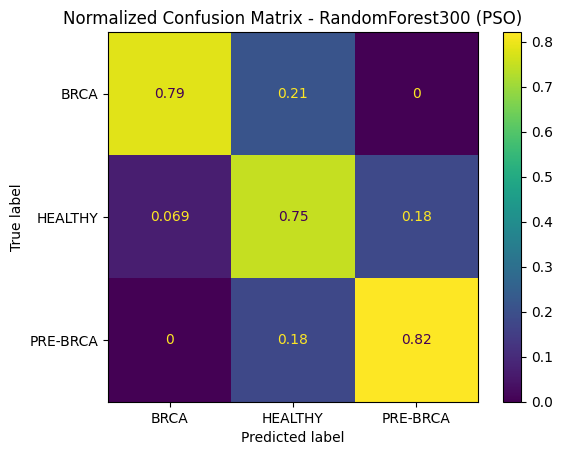


Top 20 important features:
1. cg03115886: 0.0111
2. cg01985090: 0.0108
3. cg00396163: 0.0096
4. cg03033367: 0.0090
5. cg04551655: 0.0087
6. cg03475172: 0.0084
7. cg04856689: 0.0076
8. cg03171924: 0.0073
9. cg04688368: 0.0066
10. cg03329165: 0.0066
11. cg01879488: 0.0064
12. cg03332970: 0.0064
13. cg04747322: 0.0062
14. cg04797496: 0.0062
15. cg02630694: 0.0060
16. cg03662459: 0.0059
17. cg04425624: 0.0056
18. cg01500567: 0.0055
19. cg00314943: 0.0054
20. cg02275830: 0.0053
--------------------------------------------------------------------------------
[0]	validation_0-mlogloss:1.04616
[1]	validation_0-mlogloss:1.00112


/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:17:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-mlogloss:0.95840
[3]	validation_0-mlogloss:0.91852
[4]	validation_0-mlogloss:0.87909
[5]	validation_0-mlogloss:0.84533
[6]	validation_0-mlogloss:0.81334
[7]	validation_0-mlogloss:0.78281
[8]	validation_0-mlogloss:0.75447
[9]	validation_0-mlogloss:0.72861
[10]	validation_0-mlogloss:0.70502
[11]	validation_0-mlogloss:0.68403
[12]	validation_0-mlogloss:0.66271
[13]	validation_0-mlogloss:0.64229
[14]	validation_0-mlogloss:0.62238
[15]	validation_0-mlogloss:0.60457
[16]	validation_0-mlogloss:0.58641
[17]	validation_0-mlogloss:0.57032
[18]	validation_0-mlogloss:0.55375
[19]	validation_0-mlogloss:0.54076
[20]	validation_0-mlogloss:0.52606
[21]	validation_0-mlogloss:0.51379
[22]	validation_0-mlogloss:0.50036
[23]	validation_0-mlogloss:0.48908
[24]	validation_0-mlogloss:0.47761
[25]	validation_0-mlogloss:0.46719
[26]	validation_0-mlogloss:0.45751
[27]	validation_0-mlogloss:0.44728
[28]	validation_0-mlogloss:0.43764
[29]	validation_0-mlogloss:0.42881
[30]	validation_0-mlogloss:0

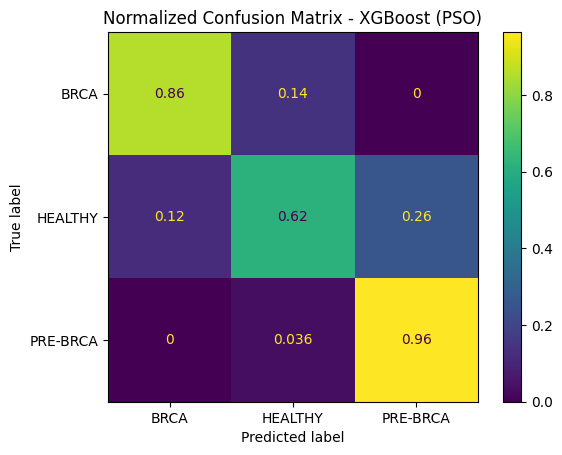


Top 20 important features:
1. cg02992647: 0.0267
2. cg00327185: 0.0256
3. cg05165580: 0.0220
4. cg02988947: 0.0215
5. cg00539322: 0.0206
6. cg01909245: 0.0180
7. cg05217755: 0.0169
8. cg04797496: 0.0153
9. cg04618607: 0.0147
10. cg04688368: 0.0123
11. cg05637351: 0.0122
12. cg01294702: 0.0108
13. cg04206644: 0.0096
14. cg02555579: 0.0091
15. cg01316789: 0.0090
16. cg04413986: 0.0089
17. cg00729708: 0.0088
18. cg03665605: 0.0086
19. cg05339472: 0.0083
20. cg04801003: 0.0078
--------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869805
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 3411
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from sc

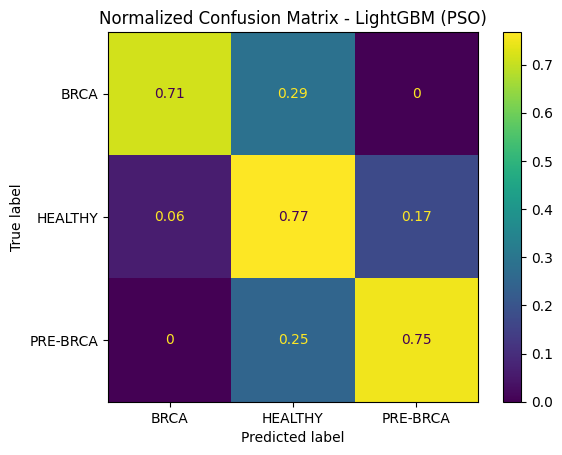


Top 20 important features:
1. cg03332970: 85.0000
2. cg05437059: 84.0000
3. cg03665605: 74.0000
4. cg03558299: 44.0000
5. cg04275881: 36.0000
6. cg03122511: 35.0000
7. cg01747191: 32.0000
8. cg05384917: 29.0000
9. cg02470959: 29.0000
10. cg04425624: 28.0000
11. cg01995513: 28.0000
12. cg05637351: 25.0000
13. cg01106788: 25.0000
14. cg01246254: 25.0000
15. cg01909245: 24.0000
16. cg03743584: 24.0000
17. cg03963198: 23.0000
18. cg04038932: 22.0000
19. cg00647741: 22.0000
20. cg04542938: 22.0000
--------------------------------------------------------------------------------

Model: GradientBoosting
Accuracy: 0.7658
F1 Score: 0.7763
ROC AUC: 0.8947
Kappa index: 0.5172


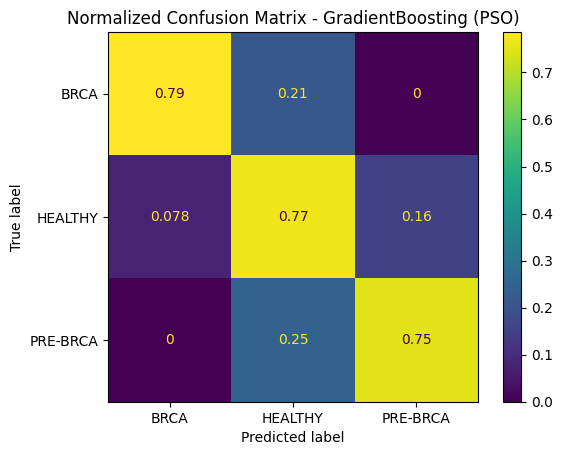


Top 20 important features:
1. cg03332970: 0.1426
2. cg05217755: 0.1219
3. cg03171924: 0.0858
4. cg04038932: 0.0853
5. cg00746981: 0.0502
6. cg01909245: 0.0482
7. cg03033367: 0.0287
8. cg04425624: 0.0218
9. cg03258472: 0.0184
10. cg05637351: 0.0175
11. cg02992647: 0.0156
12. cg05437059: 0.0101
13. cg03122511: 0.0092
14. cg03665605: 0.0077
15. cg00891541: 0.0076
16. cg04086012: 0.0070
17. cg03887787: 0.0063
18. cg00554173: 0.0061
19. cg03658707: 0.0055
20. cg02226871: 0.0054
--------------------------------------------------------------------------------


In [60]:
# Print dimensions of different training datasets
print("Training data dimensions:")
print(f"Original data (X_train_all): {X_train_all.shape}")
print(f"GA selected features (X_train_ga): {X_train_ga.shape}")
print(f"PSO selected features (X_train_pso): {X_train_pso.shape}")

for feature_set in [('GA', X_train_ga, X_test_ga, y_train_ga, y_test_ga), 
                   ('PSO', X_train_pso, X_test_pso, y_train_pso, y_test_pso)]:
    method, X_train, X_test, y_train, y_test = feature_set
    print(f"\n=== Results for {method} selected features ===")
    
    for m in modes:
        # Split training data into train and validation sets for early stopping
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
        
        if m['Name'] == 'XGBoost':
            # For XGBoost, use validation set for early stopping
            selector = m['Model'].fit(
                X_train_split, y_train_split,
                eval_set=[(X_val, y_val)],
                verbose=True
            )
        else:
            # For other models, use all training data
            selector = m['Model'].fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = selector.predict(X_test)
        y_pred_proba = selector.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        # Handle binary and multiclass cases for ROC AUC
        if y_pred_proba.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        print(f"\nModel: {m['Name']}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        # Compute Kappa index
        kappa = cohen_kappa_score(y_test, y_pred)
        print(f"Kappa index: {kappa:.4f}")

        # Confusion matrix
        disp = ConfusionMatrixDisplay.from_estimator(
            selector, X_test, y_test, normalize='true',
            display_labels=label_encoder.classes_
        )
        disp.ax_.set_title(f"Normalized Confusion Matrix - {m['Name']} ({method})")
        plt.show()

        # Feature importance (if available)
        if hasattr(selector, 'feature_importances_'):
            importances = selector.feature_importances_
            indices = np.argsort(importances)[::-1][:20]
            print("\nTop 20 important features:")
            feature_names = selected_feature_names_ga if method == 'GA' else selected_feature_names
            for rank, idx in enumerate(indices, 1):
                print(f"{rank}. {feature_names[idx]}: {importances[idx]:.4f}")
        else:
            print("\nThis model does not provide feature importances.")
        print("-" * 80)